# test keras-fcn

In [1]:
# import moduls
import sys
import random
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging

sys.path.append('./utils/')
import loadcoraldata_utils as coralutils


import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras_fcn import FCN




Using TensorFlow backend.


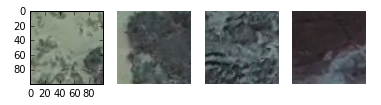

(800, 100, 100, 3) (800, 4)
(80, 100, 100, 3) (80, 4)
(80, 100, 100, 3) (80, 4)


In [2]:
# prepare training set from coral set
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'

image_size = 100

Transect1 = coralutils.CoralData(transect1_path, Truthpath=transect1_truth_path, truth_key=[16,160,198,38])
Transect1.generate_trainingset(image_size=image_size, N_train=200, idxremove = 3, figureson = True)
Transect1.generate_validset(image_size=image_size, N_valid=20, idxremove = 3, figureson = False)
Transect1.generate_testset(image_size=image_size, N_test=20, idxremove = 3, figureson = False)

if Transect1.train_labels.shape[-1] != Transect1.num_classes:
    Transect1.train_labels = keras.utils.to_categorical(Transect1.train_labels, Transect1.num_classes)
    Transect1.valid_labels = keras.utils.to_categorical(Transect1.valid_labels, Transect1.num_classes)
    Transect1.test_labels = keras.utils.to_categorical(Transect1.test_labels, Transect1.num_classes)

print(Transect1.train_datasets.shape, Transect1.train_labels.shape)
print(Transect1.valid_datasets.shape, Transect1.valid_labels.shape)
print(Transect1.test_datasets.shape, Transect1.test_labels.shape)

In [5]:
# generate pixel-wise segmented dataset for training/valid/test
#---------------------------------------------------------------
transect1_path       = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
output_trainpath     = '../Images/Training_Patches/'
output_train_refpath = '../Images/Ref_Patches_train/'
train_filename_out   = 'NeMO_train.txt'
output_validpath     = '../Images/Validation_Patches/'
output_valid_refpath = '../Images/Ref_Patches_valid/'
valid_filename_out   = 'NeMO_valid.txt'
output_testpath      = '../Images/Test_Patches/'
output_test_refpath  = '../Images/Ref_Patches_test/'
test_filename_out    = 'NeMO_test.txt'



image_size = 100
labels = ('Sand', 'Branching', 'Mounding', 'Rock')
Transect1 = coralutils.CoralData(transect1_path, Truthpath=transect1_truth_path, truth_key=[16,160,198,38])
# training set
Transect1.export_segmentation_map(output_trainpath, output_train_refpath, train_filename_out,
                        image_size=image_size, N=200, lastchannelremove = True, labelkey = labels)
# validation set
Transect1.export_segmentation_map(output_validpath, output_valid_refpath, valid_filename_out,
                        image_size=image_size, N=20, lastchannelremove = True, labelkey = labels)
# test set
Transect1.export_segmentation_map(output_testpath, output_test_refpath, test_filename_out,
                        image_size=image_size, N=20, lastchannelremove = True, labelkey = labels)





In [3]:
# run VGG-16 example test
# define general model - FCN (defualt: based on VGG16 as encoder: VGGupsampling as decoder)
fcn_vgg16 = FCN(input_shape=(image_size, image_size, 3), classes=Transect1.num_classes,  
                weights='imagenet', trainable_encoder=False)
fcn_vgg16.summary()

Loading weights...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 100, 100, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 100, 100, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 50, 50, 64)    0           block1_conv2[0][0]               
________________________________________________________________________

# Test input size and type

In [16]:
#input_shape = (100, 100, 3)
x = np.random.rand(1, image_size, image_size, 3)
y = np.random.randint(4, size=(1, image_size, image_size))
print("y shape: ",y.shape)
y = np.eye(Transect1.num_classes)[y]
print("y shape: ", y.shape)
    
    
#fcn_vgg16.fit(x, y, batch_size=1, epochs=1)
#loss = fcn_vgg16.evaluate(x, y, batch_size=1)
#assert not np.any(np.isinf(loss))
#assert not np.any(np.isnan(loss))
#y_pred = fcn_vgg16.predict(x, batch_size=1)
#assert not np.any(np.isinf(y_pred))
#assert not np.any(np.isnan(y_pred))


y shape:  (1, 100, 100)
y shape:  (1, 100, 100, 4)


## upload train and reference images

In [ ]:
fcn_vgg16.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
fcn_vgg16.fit(X_train, y_train, batch_size=1)
